---
## In part 2 of our problem, my objectives are:
- Establishing a baseline accuracy in which my models must outperform.

- Preprocessing the data to feed into my models.

- Training my models and observing how they each perform on the test set.

- Fine tuning the parameters of my models until we achieve optimal results.

- Comparing my models and evaluating their metrics in order to determine which model best achieves my goal as described in the problem statement.

---
### Imports


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# SciKit-Learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (ConfusionMatrixDisplay, balanced_accuracy_score,
                            recall_score, precision_score, f1_score, roc_auc_score, roc_curve)

### Loading the Data

In [2]:
reddit_titles = pd.read_csv('../data/subreddit_data_cleaned.csv')

In [3]:
reddit_titles.head()

,title,ID,subreddit,title_length,title_word_count,title_tokens,title_lemmatized
0,Jonathan Rée · No Foreigners: on Derrida’s Hos...,t3_1fw1nkf,philosophy,54,8,"['jonathan', 'rée', '·', 'no', 'foreigners', '...",jonathan rée · foreigner : derrida ’ hospitality
1,Introspection is a dangerous trap which lures ...,t3_1fvuxbl,philosophy,267,43,"['introspection', 'is', 'a', 'dangerous', 'tra...",introspection dangerous trap lure u illusion s...
2,The True and the Good: A Strong Virtue Theory ...,t3_1fvrkf1,philosophy,67,14,"['the', 'true', 'and', 'the', 'good', ':', 'a'...",true good : strong virtue theory value truth
3,Perhaps a major stepping stone to the good lif...,t3_1fvc7cb,philosophy,262,46,"['perhaps', 'a', 'major', 'stepping', 'stone',...",perhaps major stepping stone good life ’ striv...
4,"""Humans understand the world more easily throu...",t3_1fv5d7d,philosophy,269,44,"['``', 'humans', 'understand', 'the', 'world',...",`` human understand world easily story philoso...


In [4]:
reddit_titles.shape

(1775, 7)

### Creating our Train/Test split

In [5]:
X = reddit_titles['title']

y = reddit_titles['subreddit']

In [6]:
y.value_counts(normalize = True)

subreddit
Showerthoughts    0.570141
philosophy        0.429859
Name: proportion, dtype: float64

- If were to guess the majority class (r/Showerthoughts) every time we would have a baseline accuracy of roughly 57 percent.

- In order for our models to be considered useful we would like to improve upon this baseline.

In [11]:
# stratifying our train test split because the classes are not perfectly balanced.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [22]:
def eval_metrics(X_test, y_test, preds, model):
    '''
    Evaluate and visualize classification model performance.

    This function computes and displays evaluation metrics for a classification model, 
    including a confusion matrix, balanced accuracy, recall, precision, F1 score.

    Parameters:
        X_test (array-like): Test features.
        y_test (array-like): True labels for the test set.
        preds (array-like): Predicted labels from the model.
        model (object): Trained classification model.

    Returns:
        dict: A dictionary containing the following metrics:
            - 'balanced_accuracy': Balanced accuracy score.
            - 'recall': Recall for the positive class.
            - 'precision': Precision for the positive class.
            - 'f1_score': F1 score for the positive class.
    '''
    
    # Plot confusion matrix.
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap = 'PuBu')

    # Classification metrics.
    b_acc = balanced_accuracy_score(y_test, preds) # balanced accuracy because due to the class imbalance
    recall = recall_score(y_test, preds, pos_label = 'Showerthoughts')
    prec = precision_score(y_test, preds, pos_label = 'Showerthoughts')
    f1 = f1_score(y_test, preds, pos_label = 'Showerthoughts')

    print(f'Balanced Accuracy: {b_acc}')
    print(f'Recall: {recall}')
    print(f'Precision: {prec}')
    print(f'F1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [23]:
# I will collect my scores here and convert it to a dataframe at the end.
model_scores = []

## Iteration 1 (TfidfVectorizer and Logistic Regression):

### Pipeline

In [15]:
pipe_lr = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

### GridSearch with Cross Validation

In [16]:
pipe_lr_params = {
    'tf__max_features': range(3000, 4000, 250),
    'tf__min_df': [3, 4],
    'tf__max_df': np.linspace(0.88, 0.92, 5),
    'tf__ngram_range': [(1, 2), (1, 3)],
    'lr__penalty': [None, 'l2'],
    'lr__C': [0.09, 0.08]
}

In [17]:
gs1 = GridSearchCV(pipe_lr,
                  pipe_lr_params,
                  n_jobs = -1)

In [18]:
gs1.fit(X_train, y_train)

c:\Users\charl\anaconda3\envs\dsb\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': [0.09, 0.08], 'lr__penalty': [None, 'l2'],
                         'tf__max_df': array([0.88, 0.89, 0.9 , 0.91, 0.92]),
                         'tf__max_features': range(3000, 4000, 250),
                         'tf__min_df': [3, 4],
                         'tf__ngram_range': [(1, 2), (1, 3)]})

### Model Evalation

In [19]:
# Hyperparameters chosen after gridsearching
gs1.best_params_

{'lr__C': 0.09,
 'lr__penalty': None,
 'tf__max_df': 0.88,
 'tf__max_features': 3000,
 'tf__min_df': 3,
 'tf__ngram_range': (1, 2)}

In [20]:
print('Training Accuracy:', gs1.score(X_train, y_train))
print('Testing Accuracy:', gs1.score(X_test, y_test))

Training Accuracy: 0.9984973703981969
Testing Accuracy: 0.9054054054054054


- Because this model performed so much higher on training set than the test set I would be led to believe it is overfit, suffering from high variance.

Balanced Accuracy: 0.9060902675744469
Recall: 0.9011857707509882
Precision: 0.9306122448979591
F1 score: 0.9156626506024096


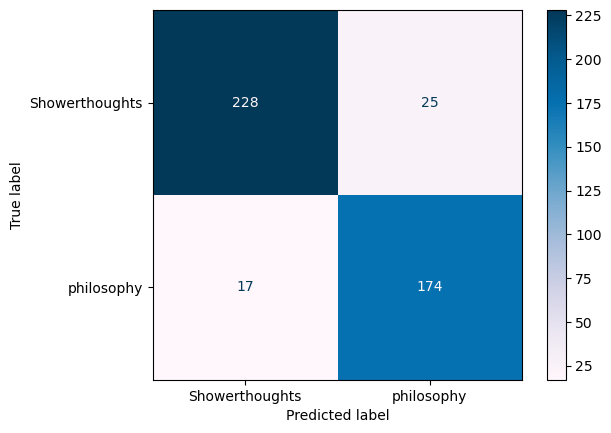

In [24]:
model_scores.append(eval_metrics(X_test, y_test, gs1.predict(X_test), gs1))

## Iteration 2 (Random Forest)

In [25]:
pipe_rf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

pipe_rf_params = {
    'tf__max_features': [3000, 4000],
    'tf__min_df': [3, 4],
    'tf__max_df': np.linspace(0.88, 0.92, 5),
    'tf__ngram_range': [(1, 2), (1, 3)],
    'rf__n_estimators': [50, 101, 50],
    'rf__max_depth': [None, 1, 2, 3],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [1, 2]
}

gs2 = GridSearchCV(pipe_rf, pipe_rf_params, cv = 5, n_jobs = -1)

gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 1, 2, 3],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 3],
                         'rf__n_estimators': [50, 101, 50],
                         'tf__max_df': array([0.88, 0.89, 0.9 , 0.91, 0.92]),
                         'tf__max_features': [3000, 4000], 'tf__min_df': [3, 4],
                         'tf__ngram_range': [(1, 2), (1, 3)]})

In [26]:
gs2.best_params_

{'rf__max_depth': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 101,
 'tf__max_df': 0.88,
 'tf__max_features': 3000,
 'tf__min_df': 3,
 'tf__ngram_range': (1, 3)}

In [27]:
print('Training Accuracy:', gs2.score(X_train, y_train))
print('Testing Accuracy:', gs2.score(X_test, y_test))

Training Accuracy: 0.9984973703981969
Testing Accuracy: 0.8738738738738738


- Training as well as our previous model but tested slightly worse, random forest is an ensemble method known for combatting high variance so this result suprises me.

Balanced Accuracy: 0.8636674047554995
Recall: 0.9367588932806324
Precision: 0.855595667870036
F1 score: 0.8943396226415095


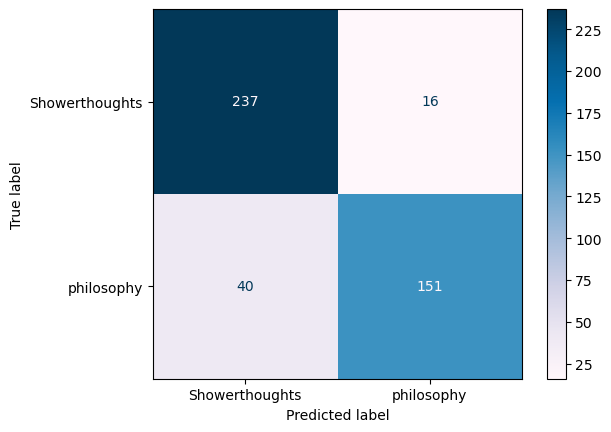

In [28]:
model_scores.append(eval_metrics(X_test, y_test, gs2.predict(X_test), gs2))

- I do find it interesting that our confusion matrix has changed in the fact that random forest seems to guess a lot more false positives.

- Due to the nature of my problem, neither false positives nor false negatives are preferred any differently, I have no reason to optimize for a specific metric such as precision/recall so I'm most interested in the accuracy/overall performance.

## Iteration 3 (Naive Bayes)

In [29]:
pipe_nb = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_nb_params = {
    'tf__max_features': [2000, 3000],
    'tf__min_df': [2, 3],
    'tf__max_df': np.linspace(0.80, 0.90, 5),
    'tf__ngram_range': [(1, 3), (1, 4)]
}

gs3 = GridSearchCV(pipe_nb, pipe_nb_params, cv = 5, n_jobs = -1)

gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tf__max_df': array([0.8  , 0.825, 0.85 , 0.875, 0.9  ]),
                         'tf__max_features': [2000, 3000], 'tf__min_df': [2, 3],
                         'tf__ngram_range': [(1, 3), (1, 4)]})

In [31]:
gs3.best_params_

{'tf__max_df': 0.8,
 'tf__max_features': 2000,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 3)}

In [32]:
print('Training Accuracy:', gs3.score(X_train, y_train))
print('Testing Accuracy:', gs3.score(X_test, y_test))

Training Accuracy: 0.9631855747558227
Testing Accuracy: 0.9031531531531531


- Assessing the metrics above and below, the Naive Bayes method seems to have remedied some high variance, I've shortened the gap in train/test scores the most with this last iteration.

Balanced Accuracy: 0.8932082031330837
Recall: 0.9644268774703557
Precision: 0.8776978417266187
F1 score: 0.9190207156308852


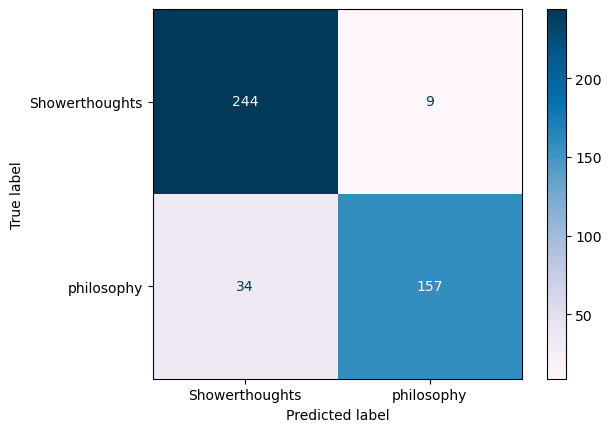

In [33]:
model_scores.append(eval_metrics(X_test, y_test, gs3.predict(X_test), gs3))

In [35]:
# Assessing our scores of each model.
pd.DataFrame(model_scores, index = ['Log Reg', 'Random Forest', 'Naive Bayes'])

,balanced_accuracy,recall,precision,f1_score
Log Reg,0.906090,0.901186,0.930612,0.915663
Random Forest,0.863667,0.936759,0.855596,0.894340
Naive Bayes,0.893208,0.964427,0.877698,0.919021


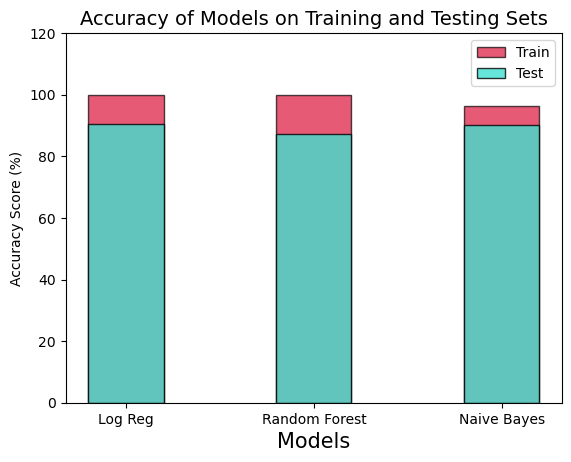

In [36]:
# Visualization of train test scores for each model
models = ['Log Reg', 'Random Forest', 'Naive Bayes']

# Multiplying scores by 100 to show as percentage
train_scores = [gs1.score(X_train, y_train)*100, gs2.score(X_train, y_train)*100, gs3.score(X_train, y_train)*100] 
test_scores = [gs1.score(X_test, y_test)*100, gs2.score(X_test, y_test)*100, gs3.score(X_test, y_test)*100] 

bar_width = 0.4

index = np.arange(len(models))

# instantiating subplots.
fig, ax = plt.subplots()

# Making overlapping bar charts
bar1 = ax.bar(index, train_scores, bar_width, label='Train', alpha=0.7, color = 'crimson', edgecolor = 'black')
bar2 = ax.bar(index, test_scores, bar_width, label='Test', alpha=0.8, color = 'turquoise', edgecolor = 'black')

# decoration
ax.set_xlabel('Models', size = 15)
ax.set_ylabel('Accuracy Score (%)')
ax.set_title('Accuracy of Models on Training and Testing Sets', size = 14)
ax.set_xticks(index)
ax.set_xticklabels(models)

# making the graph a bit taller to fit the legend
ax.set_ylim(0, 120)
ax.legend(loc='upper right')

plt.savefig('../images/model_accuracies.png')
plt.show();

# Conclusion

Is there a difference between our own self-made observations and those made by established philosophers? I believe my research shows that there are enough factors in both subreddits to substantially distinguish them, and the performance of my models backs up this claim. Using this evidence, I can answer my problem statement with a tentative yes. My models were able to find the difference in language used by both r/Showerthoughts and r/philosophy, but to continue working on this problem I would like to explore more subreddits/websites. Using only two subreddits was a very specific sample space, and I would love to explore the nuances in language across more online communities.

I would love to explore the statistics and trends of specific phrases, instead of just individual words, as this would be more relevant and reveals a lot more contextual information.
I would expect as we increased the data for our models to be trained on by more than just the two subreddits, our models could perform worse and the distinction in language might be harder to spot. But in time as research on phrases/slang increases perhaps our models would bounce back as we identify and create features which stand out in these two classes (self-made observations & professional philosophy).